# Introduction and Acknowledgement

This notebook is inspired by [Carlos Souza's Bayesian notebook](https://www.kaggle.com/carlossouza/bayesian-experiments). Go check it out! The core ideas in the code here draw heavily from this notebook.

The differences I implemented are:
* The values for FVC are in log. Rationale: I'm no expert in pulmonology, but the way I see it (or more precisely, the mental model I have of FVC), FVC is a multiplicative function of various factors. For example, starting from a baseline FVC, whether or not a person smokes would decrease her FVC by X%, a person's age would further decrease by Y%, long-term breathing from low quality air could decrease by another Z%, etc. When we consider all of these factors, the FVC would be FVC_{baseline} X (1 - X%) X (1 - Y%) X (1 - Z%) etc. This means that the variable is likely to have a log-normal distribution and therefore its log would be an appropriate transformation to the data. Another indicator that this could be appropriate is the fact that you can only have positive FVC values, never negative (which would make no sense!). More inform on log-normal distribution in the [usual place](https://en.wikipedia.org/wiki/Log-normal_distribution).
* Icalculate parameters for smoking status and age, not for each individual. Rationale: we won't have the data to estimate posterior distributions for new patients, and since the goal is to forecast out-of-sample, say, when a patient first goes to a doctor. So from my perspective, we should estimate an unpooled model on population information that the doctor has at hand at the time of first consultation, so they can share a prognosis with the patient.
* TO-DO: incorporate the image data (or the tabular predictions in the image data). Rationale: potentially very useful information. But ideally the model should be informative without the CT scan, as this would could help the medical community benefit patients without access to CT in the first place.

# Training a Bayesian log linear model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pymc3 as pm

In [2]:
exclude_test_patient_data_from_trainset = True

train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

if exclude_test_patient_data_from_trainset:
    train = train[~train['Patient'].isin(test['Patient'].unique())]

train = pd.concat([train, test], axis=0, ignore_index=True)\
    .drop_duplicates()

le_id = LabelEncoder()
train['PatientID'] = le_id.fit_transform(train['Patient'])

# The lines below are my innovations
train['FVC_original'] = train['FVC']
train['FVC'] = np.log(train['FVC'])

train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_original
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315
1,ID00007637202177411956430,5,7.702556,55.712129,79,Male,Ex-smoker,0,2214
2,ID00007637202177411956430,7,7.630947,51.862104,79,Male,Ex-smoker,0,2061
3,ID00007637202177411956430,9,7.670429,53.950679,79,Male,Ex-smoker,0,2144
4,ID00007637202177411956430,11,7.634821,52.063412,79,Male,Ex-smoker,0,2069


In [3]:
train['Male'] = train['Sex'].apply(lambda x: 1 if x == 'Male' else 0)

train["SmokingStatus"] = train["SmokingStatus"].astype(
    pd.CategoricalDtype(['Ex-smoker', 'Never smoked', 'Currently smokes'])
)
aux = pd.get_dummies(train["SmokingStatus"], prefix='ss')
aux.columns = ['ExSmoker', 'NeverSmoked', 'CurrentlySmokes']
train['CurrentlySmokes'] = aux['CurrentlySmokes']

aux = train[['Patient', 'Weeks', 'Percent']].sort_values(by=['Patient', 'Weeks'])
aux = train.groupby('Patient').head(1)
aux = aux.rename(columns={'Percent': 'Percent_base'})
train = pd.merge(train, aux[['Patient', 'Percent_base']], how='left',
                 on='Patient')

In [4]:
train.loc[train['Age'] < 50, 'YoungPatient'] = 1
train.loc[train['Age'] >= 50, 'YoungPatient'] = 0
train['YoungPatient'] = pd.get_dummies(train['YoungPatient'])

train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,PatientID,FVC_original,Male,CurrentlySmokes,Percent_base,YoungPatient
0,ID00007637202177411956430,-4,7.747165,58.253649,79,Male,Ex-smoker,0,2315,1,0,58.253649,1
1,ID00007637202177411956430,5,7.702556,55.712129,79,Male,Ex-smoker,0,2214,1,0,58.253649,1
2,ID00007637202177411956430,7,7.630947,51.862104,79,Male,Ex-smoker,0,2061,1,0,58.253649,1
3,ID00007637202177411956430,9,7.670429,53.950679,79,Male,Ex-smoker,0,2144,1,0,58.253649,1
4,ID00007637202177411956430,11,7.634821,52.063412,79,Male,Ex-smoker,0,2069,1,0,58.253649,1


In [5]:
# Hyperparameter priors for both models (one for current smokers and the other for everyone else)
FVC_smokers_mean = train.loc[train['SmokingStatus'] == 'Currently smokes', 'FVC'].mean()
FVC_smokers_stdev = train.loc[train['SmokingStatus'] == 'Currently smokes', 'FVC'].std() / 2

FVC_smokes_beta_mean = train.loc[(train['SmokingStatus'] == 'Currently smokes') & (train['Weeks'] > 70), 'FVC'].mean() - train.loc[(train['SmokingStatus'] == 'Currently smokes') & (train['Weeks'] < 10), 'FVC'].mean()
FVC_smokes_beta_weeks_mean = FVC_smokes_beta_mean / 70

FVC_nonsmokers_mean = train.loc[train['SmokingStatus'] != 'Currently smokes', 'FVC'].mean()
FVC_nonsmokers_stdev = train.loc[train['SmokingStatus'] != 'Currently smokes', 'FVC'].std() / 2

FVC_nonsmokes_beta_mean = train.loc[(train['SmokingStatus'] != 'Currently smokes') & (train['Weeks'] > 70), 'FVC'].mean() - train.loc[(train['SmokingStatus'] != 'Currently smokes') & (train['Weeks'] < 10), 'FVC'].mean()
FVC_nonsmokes_beta_weeks_mean = FVC_smokes_beta_mean / 70

In [6]:
# Data used to update priors
smokers_n_patients = train.loc[train['CurrentlySmokes'] == 1, 'Patient'].nunique()
smokers_FVC_obs = train.loc[train['CurrentlySmokes'] == 1, 'FVC'].values
smokers_PatientID = train.loc[train['CurrentlySmokes'] == 1, 'PatientID'].values

smokers_Weeks = train.loc[train['CurrentlySmokes'] == 1, 'Weeks'].values
smokers_Male = train.loc[train['CurrentlySmokes'] == 1, 'Male'].values
smokers_Young = train.loc[train['CurrentlySmokes'] == 1, 'YoungPatient'].values
smokers_Percent = train.loc[train['CurrentlySmokes'] == 1, 'Percent_base'].values

nonsmokers_n_patients = train.loc[train['CurrentlySmokes'] == 0, 'Patient'].nunique()
nonsmokers_FVC_obs = train.loc[train['CurrentlySmokes'] == 0, 'FVC'].values
nonsmokers_PatientID = train.loc[train['CurrentlySmokes'] == 0, 'PatientID'].values

nonsmokers_Weeks = train.loc[train['CurrentlySmokes'] == 0, 'Weeks'].values
nonsmokers_Male = train.loc[train['CurrentlySmokes'] == 0, 'Male'].values
nonsmokers_Young = train.loc[train['CurrentlySmokes'] == 0, 'YoungPatient'].values
nonsmokers_Percent = train.loc[train['CurrentlySmokes'] == 0, 'Percent_base'].values

In [7]:
with pm.Model() as model_smokers:
    # create shared variables that can be changed later on
    FVC_obs_shared = pm.Data("FVC_obs_shared", smokers_FVC_obs)
    PatientID_shared = pm.Data('PatientID_shared', smokers_PatientID)
    Weeks_shared = pm.Data('Weeks_shared', smokers_Weeks)
    Male_shared = pm.Data('Male_shared', smokers_Male)
    YoungPatient_shared = pm.Data('YoungPatient_shared', smokers_Young)
    Percent_shared = pm.Data('Percent_shared', smokers_Percent)
    #
    mu_a = pm.Normal('mu_a', mu = FVC_smokers_mean, sigma = FVC_smokers_stdev)
    sigma_a = pm.HalfNormal('sigma_a', 1.)
    mu_b = pm.Normal('mu_b', mu = FVC_smokes_beta_mean, sigma = 1.)
    sigma_b = pm.HalfNormal('sigma_b', 1.)
    #
    a = pm.Normal('a', mu = mu_a, sigma = sigma_a)
    b_week = pm.Normal('b_week', mu = mu_b, sigma = sigma_b)
    b_young = pm.Normal('b_young', mu = 0, sigma = 0.1)
    b_weeks_young = pm.Normal('b_weeks_young', mu = 0, sigma = 0.1)
    b_gender = pm.Normal('b_gender', mu = 0, sigma = 0.1)
    b_weeks_gender = pm.Normal('b_weeks_gender', mu = 0, sigma = 0.1)
    b_weeks_young_gender = pm.Normal('b_weeks_young_gender', mu = 0, sigma = 0.1)
    b_percent = pm.Normal('b_percent', mu = 0, sigma = 0.1)
    #
    # Model error
    sigma = pm.HalfNormal('sigma', np.log(150.))
    #
    FVC_est = a + b_week * Weeks_shared + b_young * YoungPatient_shared + b_weeks_young * Weeks_shared * YoungPatient_shared + b_gender * Male_shared + b_weeks_gender * Weeks_shared * Male_shared + b_weeks_young_gender * Weeks_shared * YoungPatient_shared * Male_shared + b_percent * Percent_shared
    #
    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu = FVC_est, sigma = sigma, observed = FVC_obs_shared)

In [8]:
with pm.Model() as model_nonsmokers:
    # create shared variables that can be changed later on
    FVC_obs_shared = pm.Data("FVC_obs_shared", nonsmokers_FVC_obs)
    PatientID_shared = pm.Data('PatientID_shared', nonsmokers_PatientID)
    Weeks_shared = pm.Data('Weeks_shared', nonsmokers_Weeks)
    Male_shared = pm.Data('Male_shared', nonsmokers_Male)
    YoungPatient_shared = pm.Data('YoungPatient_shared', nonsmokers_Young)
    Percent_shared = pm.Data('Percent_shared', nonsmokers_Percent) 
    mu_a = pm.Normal('mu_a', mu = FVC_smokers_mean, sigma = FVC_nonsmokers_stdev)
    sigma_a = pm.HalfNormal('sigma_a', 1.)
    mu_b = pm.Normal('mu_b', mu = FVC_nonsmokes_beta_mean, sigma = 1.)
    sigma_b = pm.HalfNormal('sigma_b', 1.)
    a = pm.Normal('a', mu = mu_a, sigma = sigma_a)
    b_week = pm.Normal('b_week', mu = mu_b, sigma = sigma_b)
    b_young = pm.Normal('b_young', mu = 0, sigma = 0.1)
    b_weeks_young = pm.Normal('b_weeks_young', mu = 0, sigma = 0.1)
    b_gender = pm.Normal('b_gender', mu = 0, sigma = 0.1)
    b_weeks_gender = pm.Normal('b_weeks_gender', mu = 0, sigma = 0.1)
    b_weeks_young_gender = pm.Normal('b_weeks_young_gender', mu = 0, sigma = 0.1)
    b_percent = pm.Normal('b_percent', mu = 0, sigma = 0.1)
    # Model error
    sigma = pm.HalfNormal('sigma', np.log(150.))
    FVC_est = a + b_week * Weeks_shared + b_young * YoungPatient_shared + b_weeks_young * Weeks_shared * YoungPatient_shared + b_gender * Male_shared + b_weeks_gender * Weeks_shared * Male_shared + b_weeks_young_gender * Weeks_shared * YoungPatient_shared * Male_shared + b_percent * Percent_shared
    # Data likelihood
    FVC_like = pm.Normal('FVC_like', mu = FVC_est, sigma = sigma, observed = FVC_obs_shared)

The snippet below samples the posterior distribution of the parameters for the smokers' model.

Beware: it may take a while to run.

In [11]:
with model_smokers:
    trace_smokers = pm.sample(2000, tune = 5000, target_accept = .95, init = "adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_percent, b_weeks_young_gender, b_weeks_gender, b_gender, b_weeks_young, b_young, b_week, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 999 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


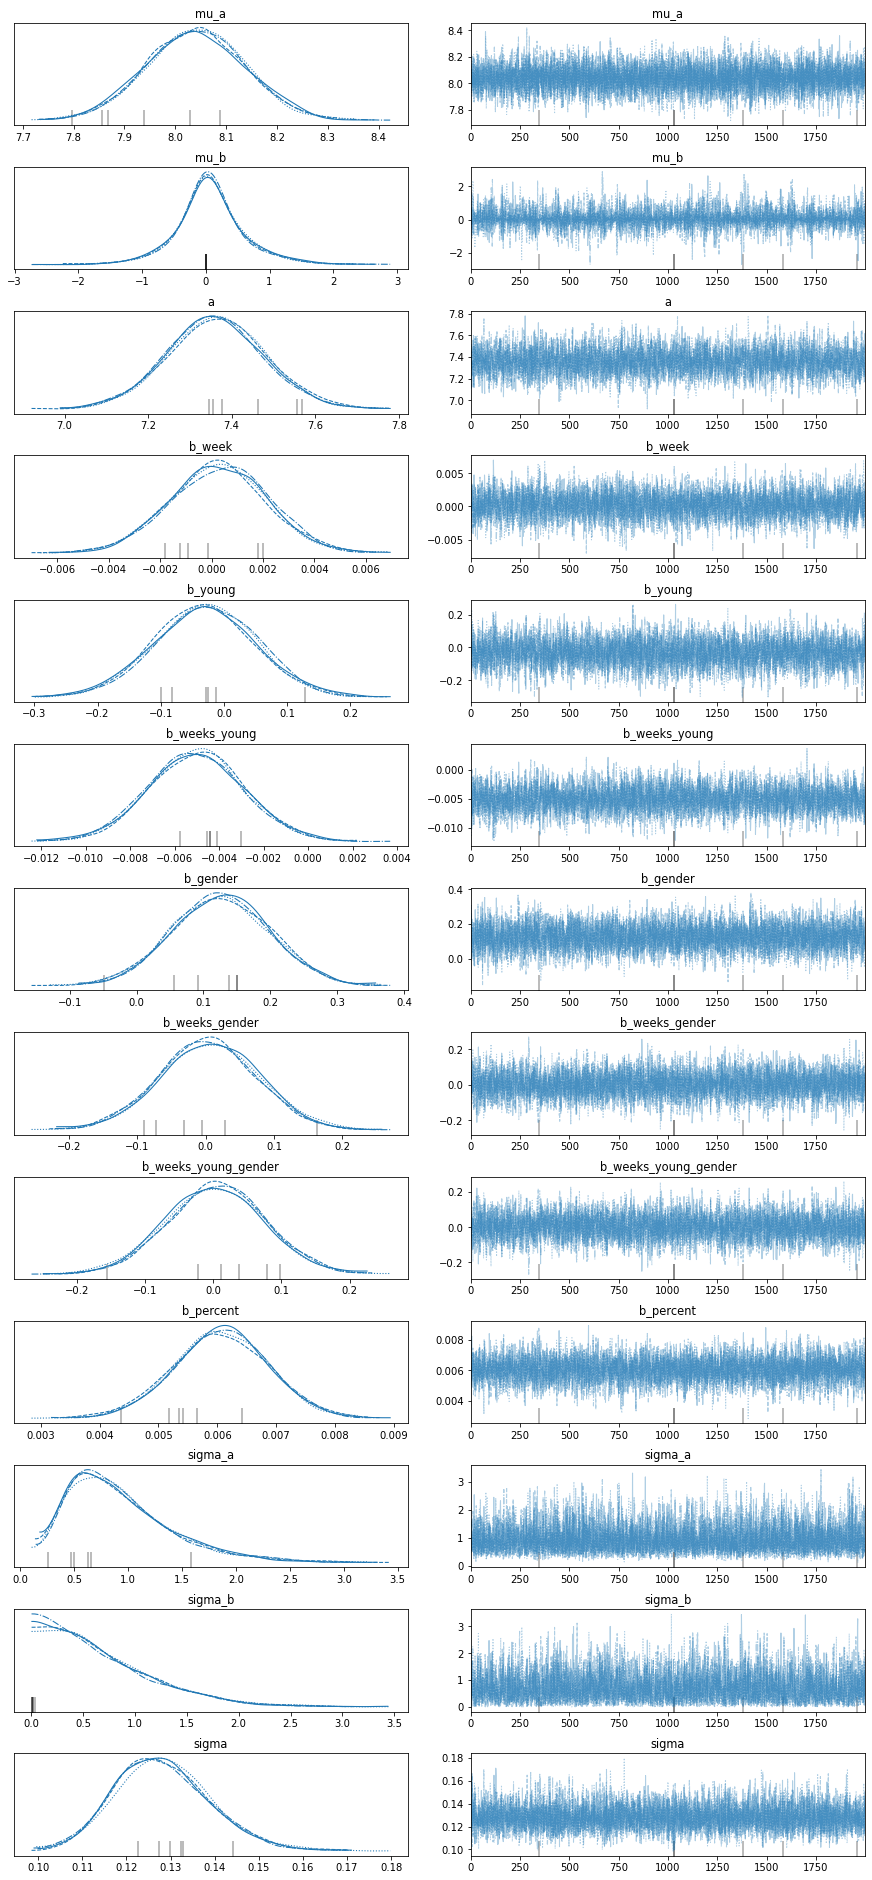

In [12]:
with model_smokers:
    pm.traceplot(trace_smokers);

Similarly, the snippet below samples the posterior distribution of the parameters from the model for non-smokers.

Beware: it may take a while to run (more than the smokers' model).

In [ ]:
with model_nonsmokers:
    trace_nonsmokers = pm.sample(2000, tune = 10000, target_accept = .95, init = "adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_percent, b_weeks_young_gender, b_weeks_gender, b_gender, b_weeks_young, b_young, b_week, a, sigma_b, mu_b, sigma_a, mu_a]


In [ ]:
with model_nonsmokers:
    pm.traceplot(trace_nonsmokers);

The snippet below compiles the training data in a way to facilitate prediction by both models.

In [ ]:
aux_train = train.groupby('Patient').first().reset_index()
pred_template_train = []
for i in range(train['Patient'].nunique()):
    df_train = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df_train['Weeks'] = np.arange(-12, 134)
    df_train['PatientID'] = i
    df_train['Male'] = aux_train[aux_train['PatientID'] == i]['Male'].values[0]
    df_train['CurrentlySmokes'] = aux_train[aux_train['PatientID'] == i]['CurrentlySmokes'].values[0]
    df_train['YoungPatient'] = aux_train[aux_train['PatientID'] == i]['YoungPatient'].values[0]
    df_train['Percent_base'] = aux_train[aux_train['PatientID'] == i]['Percent_base'].values[0]
    pred_template_train.append(df_train)
pred_template_train = pd.concat(pred_template_train, ignore_index=True)

Now we will generate predictions for smokers...

In [ ]:
with model_smokers:
    pm.set_data({
        "PatientID_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 1, 'PatientID'].values.astype(int),
        "Weeks_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 1, 'Weeks'].values.astype(int),
        "Male_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 1, 'Male'].values.astype(int),
        "YoungPatient_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 1, 'YoungPatient'].values.astype(int),
        "Percent_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 1, 'Percent_base'].values,
        "FVC_obs_shared": np.zeros(len(pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 1, :])).astype(int),
    })
    post_pred_smokers_train = pm.sample_posterior_predictive(trace_smokers)

... and prediction for non-smokers.

In [ ]:
with model_nonsmokers:
    pm.set_data({
        "PatientID_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 0, 'PatientID'].values.astype(int),
        "Weeks_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 0, 'Weeks'].values.astype(int),
        "Male_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 0, 'Male'].values.astype(int),
        "YoungPatient_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 0, 'YoungPatient'].values.astype(int),
        "Percent_shared": pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 0, 'Percent_base'].values,
        "FVC_obs_shared": np.zeros(len(pred_template_train.loc[pred_template_train['CurrentlySmokes'] == 0, :])).astype(int),
    })
    post_pred_nonsmokers_train = pm.sample_posterior_predictive(trace_nonsmokers)

Next, we need to (1) identify the patients according to smoking status, since that will determine which model will be used, and (2) use this mapping to fill out the data frame with the predictions accordingly. The first cell implements (1), and the next cell implements (2).

In [ ]:
smoker_patients_train = train.loc[train['SmokingStatus'] == 'Currently smokes', 'Patient'].unique().tolist()
nonsmoker_patients_train = train.loc[train['SmokingStatus'] != 'Currently smokes', 'Patient'].unique().tolist()

In [ ]:
df_train = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df_train['Patient'] = le_id.inverse_transform(pred_template_train['PatientID'])
df_train['Weeks'] = pred_template_train['Weeks']

# Now we have to populate the forecasts for the smokers and for the nonsmokers separately
df_train.loc[df_train['Patient'].isin(smoker_patients_train), 'FVC_pred'] = np.exp(post_pred_smokers_train['FVC_like'].T.mean(axis=1))
df_train.loc[df_train['Patient'].isin(nonsmoker_patients_train), 'FVC_pred'] = np.exp(post_pred_nonsmokers_train['FVC_like'].T.mean(axis=1))

df_train.loc[df_train['Patient'].isin(smoker_patients_train), 'sigma'] = np.exp(post_pred_smokers_train['FVC_like'].T.std(axis=1))
df_train.loc[df_train['Patient'].isin(nonsmoker_patients_train), 'sigma'] = np.exp(post_pred_nonsmokers_train['FVC_like'].T.std(axis=1))
                                                                
df_train['FVC_inf'] = df_train['FVC_pred'] / df_train['sigma']
df_train['FVC_sup'] = df_train['FVC_pred'] * df_train['sigma']

df_train = pd.merge(df_train, train[['Patient', 'Weeks', 'FVC_original']], how='left', on=['Patient', 'Weeks'])
df_train = df_train.rename(columns={'FVC_original': 'FVC_true'})
df_train.head()

OK. Let's review the steps we have taken so far:

* we loaded the training dataset;
* then we transformed the dataset according to how we are going to model the data (log linear; use of dummies);
* we set out prior distributions for the parameters in the model;
* then we used the likelihood from observed data in our model to sample the posterior distributions of our parameters of interest;
* with this posterior distribution of parameters, we have applied them to the data to generate predictions (think of it as generating the famous "y hat" vector.

We can now calculate in the following cell the modified Laplace log likelihood according to the definition used in the challenge.

In [ ]:
tr = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
df = pd.merge(df_train, tr[['Patient', 'Weeks']], how='left', on=['Patient', 'Weeks'])

use_only_last_3_measures = True

if use_only_last_3_measures:
    y = df.dropna().groupby('Patient').tail(3)
else:
    y = df.dropna()

rmse = ((y['FVC_pred'] - y['FVC_true']) ** 2).mean() ** (1/2)
print(f'Root mean squared error (RMSE): {rmse:.1f} ml')

sigma_c = y['sigma'].values.astype('float64')
sigma_c[sigma_c < 70] = 70
delta = (y['FVC_pred'] - y['FVC_true']).abs()
delta[delta > 1000] = 1000
lll = - np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f'Laplace Log Likelihood: {lll.mean():.4f}')


# Running the model on test data

Now it is time to download the test data, use the parameters as sampled from the posterior distribution to create FVC estimates (and their confidence), and compile all of this to submit to the competition.

The first snippet downloads the test data and transforms FVC to log. Subsequently the gender and smoking status transformations that were applied to training data are applied to test data. Finally, the same is done for the age < 50 years dummy.

In [ ]:
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
test['PatientID'] = le_id.fit_transform(test['Patient'])
test['FVC_original'] = test['FVC']
test['FVC'] = np.log(test['FVC'])
test.head()

In [ ]:
test['Male'] = test['Sex'].apply(lambda x: 1 if x == 'Male' else 0)

test["SmokingStatus"] = test["SmokingStatus"].astype(
    pd.CategoricalDtype(['Ex-smoker', 'Never smoked', 'Currently smokes'])
)
aux = pd.get_dummies(test["SmokingStatus"], prefix='ss')
aux.columns = ['ExSmoker', 'NeverSmoked', 'CurrentlySmokes']
test['CurrentlySmokes'] = aux['CurrentlySmokes']

aux = test[['Patient', 'Weeks', 'Percent']].sort_values(by=['Patient', 'Weeks'])
aux = test.groupby('Patient').head(1)
aux = aux.rename(columns={'Percent': 'Percent_base'})
test = pd.merge(test, aux[['Patient', 'Percent_base']], how='left',
                 on='Patient')
test.head()

In [ ]:
test.loc[train['Age'] < 50, 'YoungPatient'] = 1
test.loc[train['Age'] >= 50, 'YoungPatient'] = 0
test['YoungPatient'] = pd.get_dummies(test['YoungPatient'])

test.head()

Because we will not train the model in test data, we can now jump directly to the step where we use this pre-processed data (ie, log FVC instead of original FVC, gender dummy, current smoker dummy, young patient dummy) to generate predictions for the test patients, using the parameters sampled from the posterior distribution that we estimated using training data likelihood and our priors.

In [ ]:
aux_test = test.groupby('Patient').first().reset_index()
pred_template_test = []
for i in range(test['Patient'].nunique()):
    df_test = pd.DataFrame(columns=['PatientID', 'Weeks'])
    df_test['Weeks'] = np.arange(-12, 134)
    df_test['PatientID'] = i
    df_test['Male'] = aux_test[aux_test['PatientID'] == i]['Male'].values[0]
    df_test['CurrentlySmokes'] = aux_test[aux_test['PatientID'] == i]['CurrentlySmokes'].values[0]
    df_test['YoungPatient'] = aux_test[aux_test['PatientID'] == i]['YoungPatient'].values[0]
    df_test['Percent_base'] = aux_test[aux_test['PatientID'] == i]['Percent_base'].values[0]
    pred_template_test.append(df_test)
pred_template_test = pd.concat(pred_template_test, ignore_index=True)

In [ ]:
with model_smokers:
    if len(pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 1, :]) > 0:
        pm.set_data({
            "PatientID_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 1, 'PatientID'].values.astype(int),
            "Weeks_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 1, 'Weeks'].values.astype(int),
            "Male_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 1, 'Male'].values.astype(int),
            "YoungPatient_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 1, 'YoungPatient'].values.astype(int),
            "Percent_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 1, 'Percent_base'].values,
            "FVC_obs_shared": np.zeros(len(pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 1, :])).astype(int),
        })
        post_pred_smokers_test = pm.sample_posterior_predictive(trace_smokers)

In [ ]:
with model_nonsmokers:
    pm.set_data({
        "PatientID_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 0, 'PatientID'].values.astype(int),
        "Weeks_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 0, 'Weeks'].values.astype(int),
        "Male_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 0, 'Male'].values.astype(int),
        "YoungPatient_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 0, 'YoungPatient'].values.astype(int),
        "Percent_shared": pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 0, 'Percent_base'].values,
        "FVC_obs_shared": np.zeros(len(pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 0, :])).astype(int),
    })
    post_pred_nonsmokers_test = pm.sample_posterior_predictive(trace_nonsmokers)

In [ ]:
smoker_patients_test = test.loc[test['SmokingStatus'] == 'Currently smokes', 'Patient'].unique().tolist()
nonsmoker_patients_test = test.loc[test['SmokingStatus'] != 'Currently smokes', 'Patient'].unique().tolist()

In [ ]:
df_test = pd.DataFrame(columns=['Patient', 'Weeks', 'FVC_pred', 'sigma'])
df_test['Patient'] = le_id.inverse_transform(pred_template_test['PatientID'])
df_test['Weeks'] = pred_template_test['Weeks']

# Now we have to populate the forecasts for the smokers and for the nonsmokers separately
if len(pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 1, :]) > 0:
    df_test.loc[df_test['Patient'].isin(smoker_patients_test), 'FVC_pred'] = np.exp(post_pred_smokers_test['FVC_like'].T.mean(axis=1))
df_test.loc[df_test['Patient'].isin(nonsmoker_patients_test), 'FVC_pred'] = np.exp(post_pred_nonsmokers_test['FVC_like'].T.mean(axis=1))

if len(pred_template_test.loc[pred_template_test['CurrentlySmokes'] == 1, :]) > 0:
    df_test.loc[df_test['Patient'].isin(smoker_patients_test), 'sigma'] = np.exp(post_pred_smokers_train['FVC_like'].T.std(axis=1))
df_test.loc[df_test['Patient'].isin(nonsmoker_patients_test), 'sigma'] = np.exp(post_pred_nonsmokers_test['FVC_like'].T.std(axis=1))
                                                                
df_test['FVC_inf'] = df_test['FVC_pred'] / df_test['sigma']
df_test['FVC_sup'] = df_test['FVC_pred'] * df_test['sigma']

df_test = pd.merge(df_test, test[['Patient', 'Weeks', 'FVC_original']], how='left', on=['Patient', 'Weeks'])
df_test = df_test.rename(columns={'FVC_original': 'FVC_true'})
df_test.head()

The final step is to get the predictions we generated for the test dataset and write a CSV file according to the request format.

In [ ]:
df = df_test
df['Patient_Week'] = df['Patient'] + '_' + df['Weeks'].astype(str)
df = df.rename(columns={'FVC_pred': 'FVC'})
df['Confidence'] = (df['FVC_sup'] - df['FVC_inf']) / 2
final = df[['Patient_Week', 'FVC', 'Confidence']]
final.to_csv('submission.csv', index=False)
print(final.shape)
final.head()

Done! That's it! Now we have to work on continuing to improve the model.